In [80]:
import numpy as np
from scipy.interpolate import UnivariateSpline as Uspline
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%cd ./09_data

[Errno 2] No such file or directory: './09_data'
/Users/darioliotta/Documents/Physics of Data/Laboratory of Computational Physics/Exercises/09_data


1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



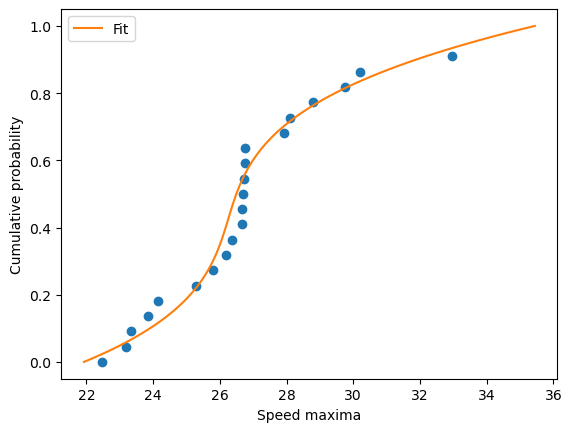

In [3]:
#Loading data
max_speeds = np.load('max-speeds.npy')
#Extracting number of years value
years_nb = max_speeds.shape[0]

#Evaluating cprob (recall that p_i=i/(N+1) with N=number of years)
cprob = np.arange(years_nb) / (years_nb + 1)
#Sorting speeds from lowest to highest
sorted_speeds = np.sort(max_speeds)
#Defining the quantile function
quantile_func = Uspline(cprob, sorted_speeds)

#Getting the fit for speed data
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)

#Getting the general fit for the quantile function
nprob = np.linspace(0, 1, 100)
fit = quantile_func(nprob)

#Plot
plt.plot(sorted_speeds, cprob, 'o')
plt.plot(fit, nprob, label = 'Fit')
plt.xlabel('Speed maxima')
plt.ylabel('Cumulative probability')
plt.legend()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

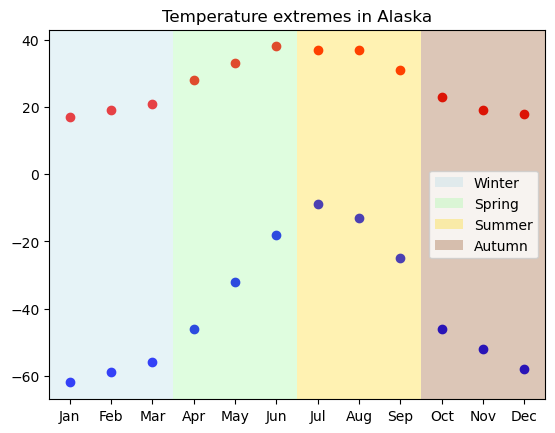

In [53]:
#We declare the two arrays and the months list
t_max = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
t_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#Scatter plot
plt.scatter(months, t_max, color = 'red')
plt.scatter(months, t_min, color = 'blue')

#Dividing the plot into seasons for better visualization
plt.xlim(-0.5,11.5)
plt.axvspan(-0.5, 2.5, facecolor = '#add8e6', alpha = 0.3, label = 'Winter')
plt.axvspan(2.5, 5.5, facecolor = '#98fb98', alpha = 0.3, label = 'Spring')
plt.axvspan(5.5, 8.5, facecolor = '#ffd700', alpha = 0.3, label = 'Summer')
plt.axvspan(8.5, 11.5, facecolor = '#8b4513', alpha = 0.3, label = 'Autumn')

#Plot
plt.title('Temperature extremes in Alaska')
plt.legend()
plt.show()

It is reasonable to consider a periodic function - such as the sine function - for the best fit of data. To spcecify the correct function we will need three parameters:

* **amplitude** $A$
* **x-shift** $x_0$
* **y-shift** $y_0$

The formula will be

$$A\sin\left[\frac{2\pi}{11}\left(x+x_0\right)\right]+y_0$$

where the factor $\frac{2\pi}{11}$ is introduced in order to make the function 11-periodic (recall that it needs to go from $0$ to $11$).

So, now the question is: how do we guess the parameters? Let's see:

* The amplitude is the distance between the largest value (in module) and the average value:

$$A=\left|\left|y_{max}\right|-\bar{y}\right|$$

* For the x-shift we consider the highest value, that we know it should be placed at a quarter period, which is $\frac{11}{4}$, so we'll consider the shift

$$x_0=\frac{11}{4}-x_{max}$$

* The y shift will simpy be

$$y_0=\bar{y}$$

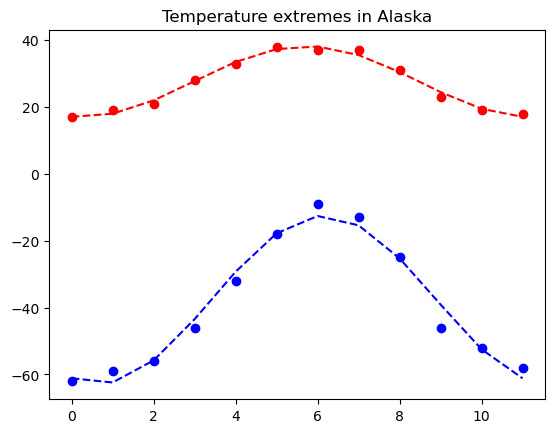

Parameters for max-temperature fit: [10.63955648 -2.97590566 27.62925851]
Parameters for min-temperature fit: [ 25.20712455  -3.40355893 -37.71075225]


In [57]:
#For calculation reasons, we re-declare 'months' as an array from 0 to 11
months = np.arange(12)

#Defining function
def fit_function(month, amplitude, xshift, yshift):
    return amplitude * np.sin(((2 * np.pi) / 11.0) * (month + xshift)) + yshift

#Defining the guess-parameters function, which returns a list with the three parameters
def guessed_params(t):
    
    #Amplitude
    absmax = abs(max(abs(np.max(t)), abs(np.min(t))))
    amplitude = abs(absmax - abs(np.mean(t)))
    
    #x shift
    xshift = ((len(t) - 1) / 4.0) - np.argmax(t)
    
    #y shift
    yshift = np.mean(t)
    
    return [amplitude, xshift, yshift]

#Plotting the scatter plot again
plt.scatter(months, t_max, color = 'red')
plt.scatter(months, t_min, color = 'blue')

#Curve fit with the two temperature arrays
params_max, covariance_max = curve_fit(fit_function, months, t_max, p0 = guessed_params(t_max))
params_min, covariance_min = curve_fit(fit_function, months, t_min, p0 = guessed_params(t_min))

#Plotting the fits
plt.plot(months, fit_function(months, *params_max), 'r--')
plt.plot(months, fit_function(months, *params_min), 'b--')

plt.title('Temperature extremes in Alaska')
plt.show()

print("Parameters for max-temperature fit:", params_max)
print("Parameters for min-temperature fit:", params_min)

In [61]:
#To verify whether those are good fits or not we can evaluate the R-squared values

predicted_values_max = fit_function(months, *params_max)
r_squared_max = 1 - np.sum((t_max - predicted_values_max)**2) / np.sum((t_max - np.mean(t_max))**2)

predicted_values_min = fit_function(months, *params_min)
r_squared_min = 1 - np.sum((t_min - predicted_values_min)**2) / np.sum((t_min - np.mean(t_min))**2)

print('R-squared for max-temperature fit:', r_squared_max)
print('R-squared for min-temperature fit:', r_squared_min)

R-squared for max-temperature fit: 0.9869247540384555
R-squared for min-temperature fit: 0.9748963027374714


It follows that the fits are reasonable.

For the last request regarding 'time offset' we need to consider the x-shift of the two curves. First, we evaluate the accuracy of the parameters, which is given by the square root of the diagonal elemets of the covariance matrix.

In [58]:
accuracy_max = np.sqrt(np.diag(covariance_max))
accuracy_min = np.sqrt(np.diag(covariance_min))

print("Fit accuracy for max temperatures:", accuracy_max)
print("Fit accuracy for min temperatures:", accuracy_min)

Fit accuracy for max temperatures: [0.40829056 0.07238048 0.30007995]
Fit accuracy for min temperatures: [1.35016571 0.09922547 0.98286081]


So we got:

$$x_0^{(max)}=-2.98\pm0.07$$
$$x_0^{(min)}=-3.40\pm0.10$$

The difference gives us:

$$x_0^{(max)}-x_0^{(min)}=0.42\pm0.17$$

So the offset is not the same, as the two functions are shifted by one or two weeks.

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


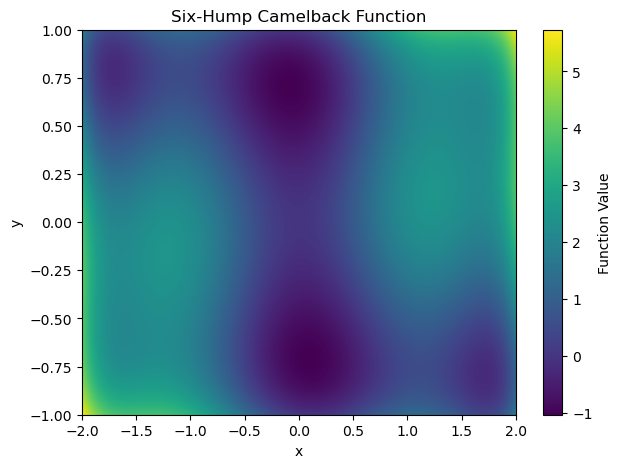

In [91]:
def f(x, y):
    return ((4 - (2.1 * x**2) + ((x**4) / 3)) * x**2) + (x * y) + (((4 * y**2) - 4) * y**2)
    
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)

plt.figure(figsize = (7, 5))
plt.imshow(f(X, Y), extent = [x.min(), x.max(), y.min(), y.max()], origin = 'lower', cmap='viridis', aspect='auto')
plt.colorbar(label = 'Function Value')
plt.title('Six-Hump Camelback Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [90]:
def obj(x):
    return f(x[0], x[1])

upper_bounds = [(-2, 2), (0, 1)]
upper_minimum = minimize(obj, (0, 0.5), bounds = upper_bounds)

lower_bounds = [(-2, 2), (-1, 0)]
lower_minimum = minimize(obj, (0, -0.5), bounds = lower_bounds)

print(f'Minimum in the upper side: f({upper_minimum.x[0]:.4f}, {upper_minimum.x[1]:.4f}) = {upper_minimum.fun}')
print(f'Minimum in the lower side: f({lower_minimum.x[0]:.4f}, {lower_minimum.x[1]:.4f}) = {lower_minimum.fun}')

Minimum in the upper side: f(-0.0898, 0.7127) = -1.031628453489875
Minimum in the lower side: f(0.0898, -0.7127) = -1.031628453489874


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.